##### 1. 몬테카를로 시뮬레이션으로 베리어옵션(Barrier Option)의 가격을 계산하는 함수를 작성하시오

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import QuantLib as ql

In [2]:
Barrier_select = 'UpOut'
flag = 'put'
S = 100  # t=0 시점 주가
K = 100  # 행사가
B = 120  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
T = 1  # 옵션 만기 (in years)
vol = 0.2  # 변동성
nsim = 2000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수

In [3]:
# Quantlib Analytic soulution
rebate = 0
barrierType = ql.Barrier.UpOut
optionType = ql.Option.Put

#Barrier Option
today = ql.Date().todaysDate()
maturity = today + ql.Period(T, ql.Years)

payoff = ql.PlainVanillaPayoff(optionType, K)
euExercise = ql.EuropeanExercise(maturity)
barrierOption = ql.BarrierOption(barrierType, B, rebate, payoff, euExercise)

#Market
spotHandle = ql.QuoteHandle(ql.SimpleQuote(S))
flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), vol, ql.Actual365Fixed()))
bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

#Pricing
barrierOption.setPricingEngine(analyticBarrierEngine)
price_as = barrierOption.NPV()

print("Analytic Price = ", price_as)

Analytic Price =  6.222684732126673


In [4]:
#벡터화 연산으로 계산한 베리어옵션 가격
def mcvector_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType):
    z = np.random.randn(nsim, m)
    st = np.zeros((nsim, m))
    st[:, 0] = S
    dt = T / m  
    
    # 각 time step에서 GBM 모델을 이용해 주가 변화율 계산
    schange = np.exp((r - q - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z)
    # 누적 곱을 이용해 시점별 주가 계산
    st[:, 1:] = S * np.cumprod(schange[:, 1:], axis=1)
    callOrPut = 1 if flag.lower()=='call' else -1
    # 베리어 조건
    if barrierType == 'UpOut':
        knocked_out = np.max(st, axis=1) >= B 
        payoff = np.maximum(callOrPut*(st[:, -1] - K), 0) 
        payoff[knocked_out] = 0 

    elif barrierType == 'UpIn':
        knocked_in = np.max(st, axis=1) >= B  
        payoff = np.zeros(nsim)
        payoff[knocked_in] = np.maximum(callOrPut*(st[knocked_in, -1] - K), 0)

    elif barrierType == 'DownOut':
        knocked_out = np.min(st, axis=1) <= B 
        payoff = np.maximum(callOrPut*(st[:, -1] - K), 0)
        payoff[knocked_out] = 0  
        
    elif barrierType == 'DownIn':
        knocked_in = np.min(st, axis=1) <= B  
        payoff = np.zeros(nsim)
        payoff[knocked_in] = np.maximum(callOrPut*(st[knocked_in, -1] - K), 0) 
    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * T) * payoff
    price = np.mean(discounted_payoff)
    
    return price

price_ms= mcvector_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType = Barrier_select)
pricediff = price_as - price_ms

print(f"Monte Carlo Barrier Option Price with Vectorized operation = {price_ms:.6f}")
print("Analytic Price = ", price_as)
print(f"Price difference = {pricediff:.6f}")

Monte Carlo Barrier Option Price with Vectorized operation = 6.314497
Analytic Price =  6.222684732126673
Price difference = -0.091812


In [5]:
#루프문으로 계산한 베리어 옵션의 가격격
def mcLoop_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType):
    dt = T / m
    callOrPut = 1 if flag.lower() == 'call' else -1

    discounted_payoff = []

    for simulation in range(nsim):
        st = S 
        InOut_status = False
        for step in range(m):
            st *= np.exp((r - q - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * np.random.randn())

            if barrierType == 'UpOut' and st >= B:
                InOut_status = True
                break  

            elif barrierType == 'DownOut' and st <= B:
                InOut_status = True
                break  

            elif barrierType == 'UpIn' and st >= B:
                InOut_status = True

            elif barrierType == 'DownIn' and st <= B:
                InOut_status = True

        if barrierType in ['UpOut', 'DownOut']:
            if InOut_status == True:
                payoff = 0  
            else:
                payoff = max(callOrPut * (st - K), 0) 

        elif barrierType in ['UpIn', 'DownIn']:
            if InOut_status == True:
                payoff = max(callOrPut * (st - K), 0)  
            else:
                payoff = 0 

        discounted_payoff.append(np.exp(-r * T) * payoff)

    price = np.mean(discounted_payoff)

    return price

price_msloop = mcLoop_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType=Barrier_select)

pricediff = price_as - price_msloop

print(f"Monte Carlo Barrier Option Price with loop operation = {price_ms:.6f}")
print("Analytic Price = ", price_as)
print(f"Price difference = {pricediff:.6f}")


Monte Carlo Barrier Option Price with loop operation = 6.314497
Analytic Price =  6.222684732126673
Price difference = 0.101979


In [6]:
#벡터화연산과 루프 계산시간 비교
%time mcvector_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType='UpOut')
%time mcLoop_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType='UpOut')

CPU times: total: 93.8 ms
Wall time: 120 ms
CPU times: total: 2.7 s
Wall time: 4.58 s


6.001727128129303

##### 2. 베리어옵션의 In-Out parity에 대해서 조사하고, 몬테카를로 옵션평가에서 활용할 수 있는 방법에 대해서 설명하시오.

In [7]:
# In-Out Parity 검증
def mcprice(S, K, r, q, T, vol,nsim,flag):
    z = np.random.randn(nsim)
    st = S*np.exp((r-q-0.5*vol**2)*T + vol*np.sqrt(T)*z)
    callOrPut = 1 if flag.lower()=='Call' else -1    
    payoff = np.maximum(callOrPut*(st-K), 0)    
    disc_payoff = np.exp(-r*T)*payoff
    price = disc_payoff.mean()    
    return price

price_bs = mcprice(S, K, r, q, T, vol, nsim, flag)
price_UpOut = mcvector_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType = 'UpOut')
Derived_UpIn = price_bs - price_UpOut
price_UpIn = mcvector_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType='UpIn')

print(f"Price difference = {Derived_UpIn - price_UpIn:.6f}")

Price difference = -0.129743


In [8]:
#Knock-In Knock-Out 계산시간 비교
%time mcLoop_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType='UpOut')
%time mcprice(S, K, r, q, T, vol,nsim,flag)
%time mcLoop_barrier_price(S, K, B, r, q, T, vol, nsim, m, flag, barrierType='UpIn')

CPU times: total: 1.89 s
Wall time: 4.1 s
CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 2.66 s
Wall time: 5.18 s


0.17304129099230056

##### 3. m과 n을 변경할 떄, bias와 variance의 변화를 시뮬레이션 결과로 설명하시오.

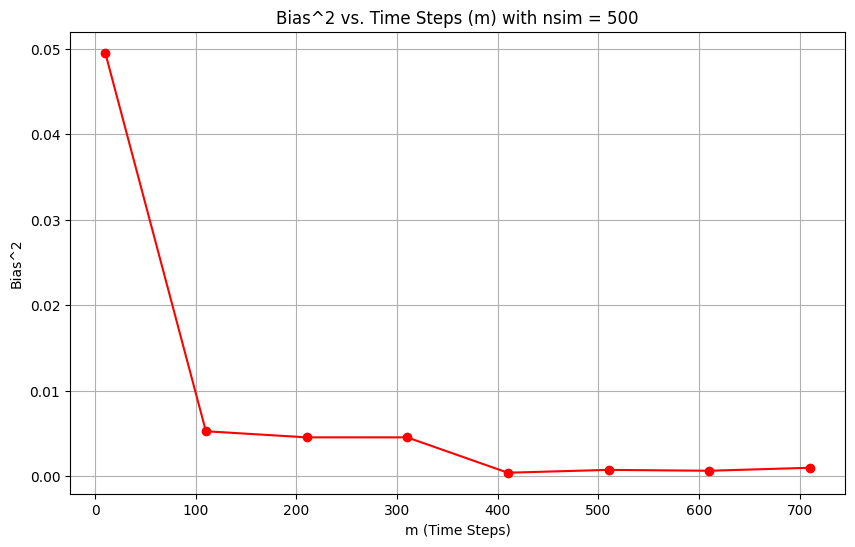

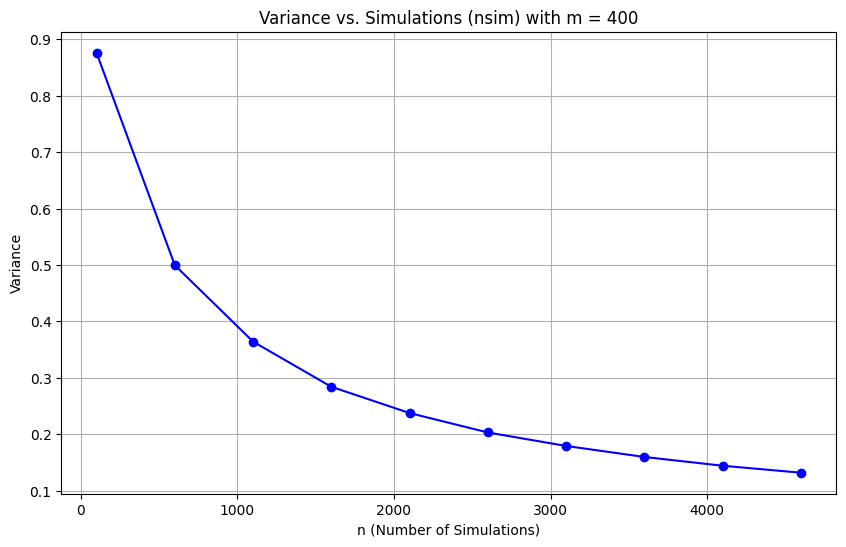

In [9]:
analytic_price = price_as

m_values = range(10, 801, 100)  
nsim_values = range(100, 5001, 500)
A = 30 # 몬테카를로 시뮬레이션 베리어 옵션 가격 샘플 수 
np.random.seed(123)
bias_data = []
variance_data = []
price_bias = []
price_variance = []

# Fix nsim = 2000, variable = m, Bias^2 data 구하기
for m in m_values:
    for i in range(A):
        price = mcvector_barrier_price(S, K, B, r, q, T, vol, nsim=500, m=m, flag=flag, barrierType=Barrier_select)
        price_bias.append(price)
    avg_price = np.mean(price_bias)
    bias = (analytic_price - avg_price)**2
    bias_data.append((m, bias))

# Generate variance data for fixed m = 400, varying nsim
for nsim in nsim_values:
    for i in range(A):
        price = mcvector_barrier_price(S, K, B, r, q, T, vol, nsim=nsim, m=400, flag=flag, barrierType=Barrier_select)
        price_variance.append(price)
    variance = (np.std(price_variance, ddof=1))**2
    variance_data.append((nsim, variance))

# Plotting Bias vs. m (with nsim = 400 fixed)
bias_df = pd.DataFrame(bias_data, columns=['m', 'Bias'])
plt.figure(figsize=(10, 6))
plt.plot(bias_df['m'], bias_df['Bias'], 'o-', color='red', label='Bias')
plt.xlabel('m (Time Steps)')
plt.ylabel('Bias^2')
plt.title('Bias^2 vs. Time Steps (m) with nsim = 500')
plt.grid(True)
plt.show()

# Plotting Variance vs. nsim (with m = 400 fixed)
variance_df = pd.DataFrame(variance_data, columns=['nsim', 'Variance'])
plt.figure(figsize=(10, 6))
plt.plot(variance_df['nsim'], variance_df['Variance'], 'o-', color='blue', label='Variance')
plt.xlabel('n (Number of Simulations)')
plt.ylabel('Variance')
plt.title('Variance vs. Simulations (nsim) with m = 400')
plt.grid(True)
plt.show()


Simulation Results
   nsim    m   Variance     Bias^2        MSE
0     2  512  50.317008   0.338353  50.655361
1     4  256  22.644897   0.097557  22.742454
2     8  128   9.171775   0.146053   9.317827
3    16   64   6.948005   0.099416   7.047420
4    32   32   2.701888   0.030700   2.732588
5    64   16   1.503204   0.001195   1.504398
6   128    8   0.601388   0.018582   0.619970
7   256    4   0.292067   0.288743   0.580810
8   512    2   0.114081   1.991219   2.105301
9  1024    1   0.000000  38.721805  38.721805


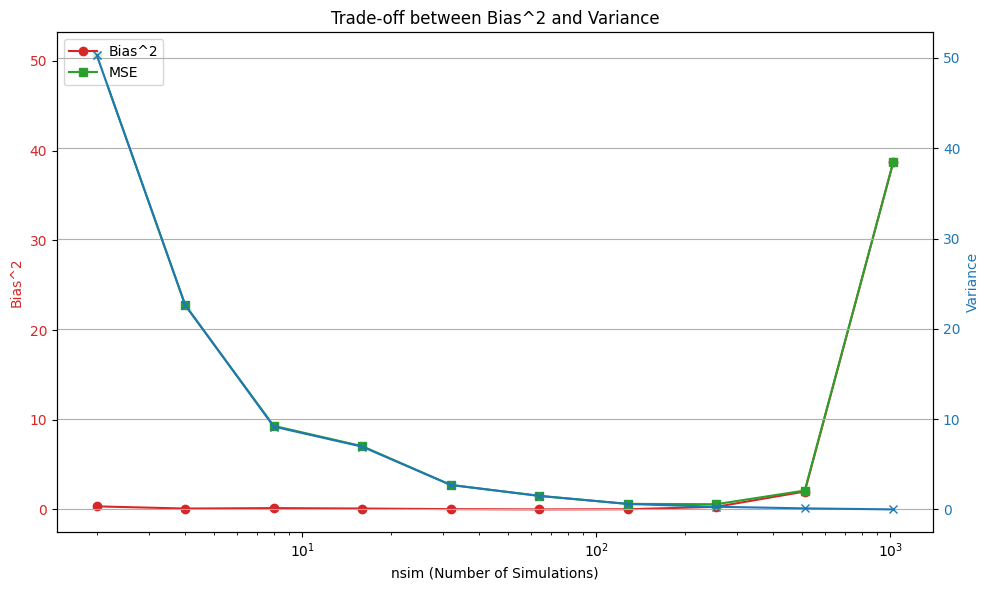

: 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123)
C = 2**10  # 계산예산
x = range(1,11,1)
nsim_values =  [2**i for i in x]
A = 50  
analytic3_price = price_as  

bias_data = []
variance_data = []
mse_data = []

for nsim in nsim_values:
    m = int(C / nsim) 
    price_bias = []
    price_variance = []
    
    for i in range(A):
        price = mcvector_barrier_price(S, K, B, r, q, T, vol, nsim=nsim, m=m, flag=flag, barrierType=Barrier_select)
        price_bias.append(price)
        price_variance.append(price)
    
    avg_price = np.mean(price_bias)
    bias = (analytic_price - avg_price) ** 2
    variance = (np.std(price_variance, ddof=1)) ** 2 

    mse = bias + variance

    bias_data.append(bias)
    variance_data.append(variance)
    mse_data.append(mse)

results_df = pd.DataFrame({
    'nsim': nsim_values,
    'm': [int(C / nsim) for nsim in nsim_values],
    'Variance': variance_data,
    'Bias^2': bias_data,
    'MSE': mse_data
})

print("Simulation Results")
print(results_df)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('nsim (Number of Simulations)')
ax1.set_ylabel('Bias^2', color=color)
ax1.plot(nsim_values, bias_data, 'o-', color=color, label='Bias^2')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)  
ax2.plot(nsim_values, variance_data, 'x-', color=color, label='Variance')
ax2.tick_params(axis='y', labelcolor=color)
ax1.plot(nsim_values, mse_data, 's-', color='tab:green', label='MSE')
ax1.legend(loc='upper left')

ax1.set_xscale('log')
ax2.set_xscale('log')

plt.title('Trade-off between Bias^2 and Variance')
plt.grid(True)

plt.tight_layout()
plt.show()
